# Tune the meta model
 
We want to check if we can exchange the metamodel from Ridge to DNN

We use the best base model parameters from the previous notebooks

# Model v4.0 - Baseline model with added DNN base estimator

In [1]:
from fileinput import filename

import pandas as pd

from data import load_data_selected_features

train_data, additional_train_data, test_data = load_data_selected_features()

In [2]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 150996 entries, p01_0 to p12_25298
Columns: 507 entries, p_num to bg+1:00
dtypes: float64(433), object(74)
memory usage: 585.2+ MB


In [3]:
additional_train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 168588 entries, p01_test_12 to p24_test_94938
Columns: 507 entries, p_num to bg+1:00
dtypes: float64(433), object(74)
memory usage: 657.4+ MB


In [4]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3644 entries, p01_8459 to p24_260
Columns: 506 entries, p_num to activity-0:00
dtypes: float64(432), object(74)
memory usage: 14.2+ MB


# Prepare the data

In [5]:
from pipelines_selected_features import pipeline

all_train_data = pd.concat([train_data, additional_train_data], axis=0)
all_train_data_transformed = pipeline.fit_transform(all_train_data)

train_data_transformed = all_train_data_transformed[:len(train_data)]
additional_train_data_transformed = all_train_data_transformed[len(train_data):]

X_train = train_data_transformed.drop(columns=['bg+1:00'])
y_train = train_data_transformed['bg+1:00']

X_additional_train = additional_train_data_transformed.drop(columns=['bg+1:00'])
y_additional_train = additional_train_data_transformed['bg+1:00']

## Predict for validation data and check results

In [6]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Concatenate
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input, Activation
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasRegressor


def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))


def create_dnn_model(input_dimension: int):
    input_layer = Input(shape=(input_dimension,))
    wide = Dense(128, activation='relu')(input_layer)  # Wide component
    deep = Dense(128, activation='relu')(input_layer)
    deep = Dense(64, activation='relu')(deep)
    deep = Dense(32, activation='relu')(deep)

    merged = Concatenate()([wide, deep])
    output_layer = Dense(1, activation='linear')(merged)

    dnn_model = Model(inputs=input_layer, outputs=output_layer)
    dnn_model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse',
        metrics=[rmse]
    )

    return dnn_model


def model_with_pretrained_weights():
    dnn = create_dnn_model(X_train.shape[1])
    dnn.load_weights('v4.0-dnn.weights.h5')  # Load the pre-trained weights

    # Freeze all layers except the last one (optional)
    for layer in dnn.layers:
        layer.trainable = False
    # Unfreeze the output layer if you want to fine-tune it
    # dnn.layers[-1].trainable = True

    dnn.compile(optimizer='adam', loss='mse', metrics=[rmse])
    return dnn


In [7]:
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import StackingRegressor, HistGradientBoostingRegressor
from sklearn.linear_model import LassoLarsIC, Ridge

hgb_estimator = HistGradientBoostingRegressor(max_iter=200, max_depth=5, learning_rate=0.1)
lasso_lars_ic_base_model = LassoLarsIC(criterion='bic', max_iter=10000)
knn_base_model = KNeighborsRegressor(n_neighbors=5)
xgb_base_model = XGBRegressor(objective='reg:squarederror', random_state=42, n_estimators=500, max_depth=5, learning_rate=0.1)

# pretrain the DNN and use the weights in the stacking model
pretrained_dnn = create_dnn_model(X_train.shape[1])
pretrained_dnn.fit(pd.concat([X_train, X_additional_train], axis=0), pd.concat([y_train, y_additional_train], axis=0), epochs=100, verbose=2)
pretrained_dnn.save_weights('v4.0-dnn.weights.h5')

keras_regressor = KerasRegressor(
    model=model_with_pretrained_weights,
    epochs=1,
    verbose=2
)

estimators = [
    ('hgb', hgb_estimator),
    ('lasso_lars_ic', lasso_lars_ic_base_model),
    ('knn', knn_base_model),
    ('xgb', xgb_base_model),
    ('dnn', keras_regressor)
]

model = StackingRegressor(estimators=estimators, final_estimator=Ridge(alpha=0.1), n_jobs=1, verbose=2)

Epoch 1/100
9987/9987 - 5s - 481us/step - loss: 4.5814 - rmse: 2.0836
Epoch 2/100
9987/9987 - 4s - 431us/step - loss: 4.0299 - rmse: 1.9763
Epoch 3/100
9987/9987 - 4s - 434us/step - loss: 3.9042 - rmse: 1.9453
Epoch 4/100
9987/9987 - 4s - 434us/step - loss: 3.8410 - rmse: 1.9258
Epoch 5/100
9987/9987 - 4s - 434us/step - loss: 3.7473 - rmse: 1.9050
Epoch 6/100
9987/9987 - 4s - 433us/step - loss: 3.6859 - rmse: 1.8902
Epoch 7/100
9987/9987 - 4s - 435us/step - loss: 3.6575 - rmse: 1.8792
Epoch 8/100
9987/9987 - 4s - 437us/step - loss: 3.5909 - rmse: 1.8640
Epoch 9/100
9987/9987 - 5s - 454us/step - loss: 3.5329 - rmse: 1.8502
Epoch 10/100
9987/9987 - 4s - 437us/step - loss: 3.5322 - rmse: 1.8426
Epoch 11/100
9987/9987 - 4s - 439us/step - loss: 3.4525 - rmse: 1.8289
Epoch 12/100
9987/9987 - 6s - 566us/step - loss: 3.4538 - rmse: 1.8215
Epoch 13/100
9987/9987 - 4s - 438us/step - loss: 3.3954 - rmse: 1.8102
Epoch 14/100
9987/9987 - 4s - 446us/step - loss: 3.3828 - rmse: 1.8029
Epoch 15/100
99

11:30:35 - Start training
11:30:35 - Calculate performance for dnn
11:30:35 - Selected splitter: ShuffleSplit(n_splits=5, random_state=42, test_size=0.2, train_size=None)
11:30:35 - Split 1 - Model: dnn
11:30:35 - Fitting the model


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


8934/8934 - 2s - 261us/step - loss: 2.6832 - rmse: 3.9880
11:30:38 - Predicting
1054/1054 - 0s - 331us/step
11:30:38 - Calculating scores
11:30:38 - R^2: 0.7497131334593787, RMSE: 1.6397465650534253, MAE: 1.2022148439783638, MSE: 2.6887687976045074
11:30:38 - Split 2 - Model: dnn
11:30:38 - Fitting the model


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


8934/8934 - 2s - 264us/step - loss: 2.6956 - rmse: 3.9880
11:30:41 - Predicting
1054/1054 - 0s - 310us/step
11:30:41 - Calculating scores
11:30:41 - R^2: 0.7602985387436147, RMSE: 1.6072776529467665, MAE: 1.2050102010484027, MSE: 2.583341453662066
11:30:41 - Split 3 - Model: dnn
11:30:41 - Fitting the model


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


8934/8934 - 2s - 268us/step - loss: 2.6705 - rmse: 3.9928
11:30:44 - Predicting
1054/1054 - 0s - 310us/step
11:30:44 - Calculating scores
11:30:44 - R^2: 0.735253421047094, RMSE: 1.6720714023085907, MAE: 1.2087362299794735, MSE: 2.795822774418217
11:30:44 - Split 4 - Model: dnn
11:30:44 - Fitting the model


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


8934/8934 - 2s - 259us/step - loss: 2.6926 - rmse: 3.9849
11:30:47 - Predicting
1054/1054 - 0s - 318us/step
11:30:47 - Calculating scores
11:30:47 - R^2: 0.7586479749975399, RMSE: 1.6151057210577273, MAE: 1.2065136133517878, MSE: 2.6085664901934016
11:30:47 - Split 5 - Model: dnn
11:30:47 - Fitting the model


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


8934/8934 - 2s - 264us/step - loss: 2.6693 - rmse: 3.9906
11:30:50 - Predicting
1054/1054 - 0s - 313us/step
11:30:50 - Calculating scores
11:30:50 - R^2: 0.733703364293379, RMSE: 1.6750346526407907, MAE: 1.208699423887105, MSE: 2.8057410875474544
11:30:50 - Training finished
11:30:50 - Calculate performance for hgb
11:30:50 - Selected splitter: ShuffleSplit(n_splits=5, random_state=42, test_size=0.2, train_size=None)
11:30:50 - Split 1 - Model: hgb
11:30:51 - Fitting the model
11:30:58 - Predicting
11:30:58 - Calculating scores
11:30:58 - R^2: 0.617191876220058, RMSE: 2.02790810983657, MAE: 1.507343466406819, MSE: 4.11241130194093
11:30:58 - Split 2 - Model: hgb
11:30:58 - Fitting the model
11:31:06 - Predicting
11:31:06 - Calculating scores
11:31:06 - R^2: 0.6132856402146292, RMSE: 2.041506256164435, MAE: 1.5221126463072676, MSE: 4.167747793958529
11:31:06 - Split 3 - Model: hgb
11:31:06 - Fitting the model
11:31:14 - Predicting
11:31:14 - Calculating scores
11:31:14 - R^2: 0.61529969

/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


8934/8934 - 3s - 354us/step - loss: 2.6831 - rmse: 3.9867


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


7147/7147 - 2s - 262us/step - loss: 2.6091 - rmse: 4.0470
1787/1787 - 1s - 290us/step


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


7147/7147 - 2s - 260us/step - loss: 2.7956 - rmse: 4.0199
1787/1787 - 1s - 293us/step


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


7147/7147 - 2s - 271us/step - loss: 2.7933 - rmse: 4.0060
1787/1787 - 1s - 302us/step


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


7147/7147 - 2s - 266us/step - loss: 2.5669 - rmse: 3.9211
1787/1787 - 1s - 416us/step


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


7147/7147 - 2s - 278us/step - loss: 2.6507 - rmse: 3.9287
1787/1787 - 1s - 295us/step
11:35:30 - Predicting
1054/1054 - 0s - 326us/step
11:35:39 - Calculating scores
11:35:39 - R^2: 0.7592795850814751, RMSE: 1.60810410613852, MAE: 1.1836564433869878, MSE: 2.5859988161795684
11:35:39 - Split 2 - Model: stacking_regressor
11:35:39 - Fitting the model


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


8934/8934 - 2s - 264us/step - loss: 2.6956 - rmse: 3.9841


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


7147/7147 - 2s - 259us/step - loss: 2.6247 - rmse: 4.0439
1787/1787 - 1s - 292us/step


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


7147/7147 - 2s - 256us/step - loss: 2.8112 - rmse: 4.0205
1787/1787 - 1s - 290us/step


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


7147/7147 - 2s - 259us/step - loss: 2.7924 - rmse: 3.9977
1787/1787 - 1s - 292us/step


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


7147/7147 - 2s - 256us/step - loss: 2.6059 - rmse: 3.9260
1787/1787 - 1s - 291us/step


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


7147/7147 - 2s - 259us/step - loss: 2.6438 - rmse: 3.9333
1787/1787 - 1s - 293us/step
11:38:13 - Predicting
1054/1054 - 0s - 319us/step
11:38:23 - Calculating scores
11:38:23 - R^2: 0.7671680236922251, RMSE: 1.5840791507741896, MAE: 1.1870475549066877, MSE: 2.5093067559174775
11:38:23 - Split 3 - Model: stacking_regressor
11:38:23 - Fitting the model


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


8934/8934 - 2s - 256us/step - loss: 2.6705 - rmse: 3.9919


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


7147/7147 - 2s - 268us/step - loss: 2.5934 - rmse: 4.0509
1787/1787 - 1s - 306us/step


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


7147/7147 - 2s - 267us/step - loss: 2.7799 - rmse: 4.0265
1787/1787 - 1s - 298us/step


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


7147/7147 - 2s - 273us/step - loss: 2.7174 - rmse: 4.0068
1787/1787 - 1s - 310us/step


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


7147/7147 - 2s - 348us/step - loss: 2.5576 - rmse: 3.9207
1787/1787 - 2s - 887us/step


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


7147/7147 - 2s - 260us/step - loss: 2.7045 - rmse: 3.9390
1787/1787 - 1s - 292us/step
11:40:56 - Predicting
1054/1054 - 0s - 316us/step
11:41:06 - Calculating scores
11:41:06 - R^2: 0.7479618219093631, RMSE: 1.6314463870655196, MAE: 1.1876555148380923, MSE: 2.661617313869137
11:41:06 - Split 4 - Model: stacking_regressor
11:41:06 - Fitting the model


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


8934/8934 - 3s - 328us/step - loss: 2.6926 - rmse: 3.9852


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


7147/7147 - 2s - 330us/step - loss: 2.6210 - rmse: 4.0430
1787/1787 - 1s - 350us/step


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


7147/7147 - 2s - 340us/step - loss: 2.8075 - rmse: 4.0203
1787/1787 - 1s - 319us/step


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


7147/7147 - 2s - 289us/step - loss: 2.8042 - rmse: 4.0050
1787/1787 - 1s - 306us/step


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


7147/7147 - 3s - 387us/step - loss: 2.6150 - rmse: 3.9231
1787/1787 - 1s - 456us/step


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


7147/7147 - 2s - 323us/step - loss: 2.6154 - rmse: 3.9279
1787/1787 - 1s - 396us/step
11:43:56 - Predicting
1054/1054 - 0s - 352us/step
11:44:06 - Calculating scores
11:44:06 - R^2: 0.7653336649231749, RMSE: 1.5925786062464253, MAE: 1.1894176171771964, MSE: 2.5363066170738064
11:44:06 - Split 5 - Model: stacking_regressor
11:44:06 - Fitting the model


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


8934/8934 - 3s - 295us/step - loss: 2.6694 - rmse: 3.9894


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


7147/7147 - 2s - 294us/step - loss: 2.5919 - rmse: 4.0485
1787/1787 - 1s - 320us/step


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


7147/7147 - 2s - 300us/step - loss: 2.7784 - rmse: 4.0242
1787/1787 - 1s - 322us/step


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


7147/7147 - 2s - 293us/step - loss: 2.7405 - rmse: 4.0140
1787/1787 - 1s - 326us/step


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


7147/7147 - 2s - 313us/step - loss: 2.6780 - rmse: 3.9256
1787/1787 - 1s - 341us/step


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


7147/7147 - 3s - 402us/step - loss: 2.5580 - rmse: 3.9269
1787/1787 - 1s - 345us/step
11:46:50 - Predicting
1054/1054 - 0s - 354us/step
11:46:59 - Calculating scores
11:46:59 - R^2: 0.7451516957655367, RMSE: 1.6386335035533521, MAE: 1.1905674676168998, MSE: 2.685119758967534
11:46:59 - Training finished
Final estimator RMSE: 1.6109683507556014
Final estimator R2: 0.7569789582743549
Final estimator MSE: 2.595669852401505
Final estimator MAE: 1.1876689195851726


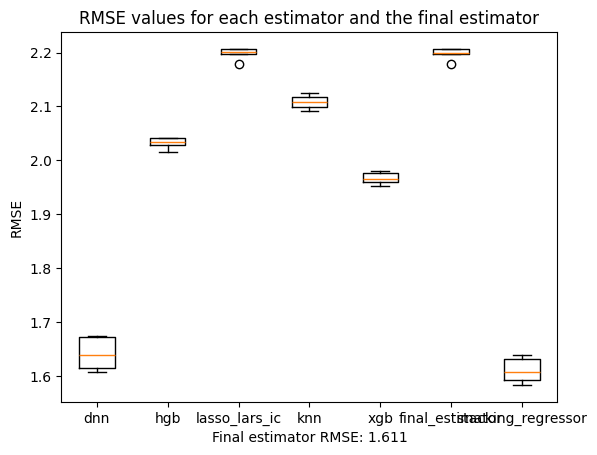

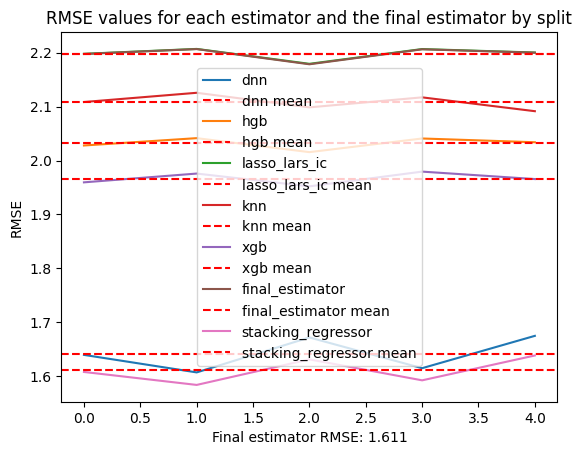

In [8]:
from datetime import datetime
import os
from model_performance_calculations import calculate_stacking_regressor_performance, get_rmse_boxplot_chart, get_rmse_line_chart, save_performances, save_model

date_time = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
model_name = f'{date_time}-model-v4.0-DNN'

save_model(model, os.path.join('models', f'{model_name}.pkl'))

performances = calculate_stacking_regressor_performance(model, X_train, y_train, X_additional_train, y_additional_train, n_splits=5)
save_performances(performances, os.path.join('models', f'{model_name}-performances.json'))

get_rmse_boxplot_chart(performances).show()
get_rmse_line_chart(performances).show()

In [9]:
import numpy as np
from pipelines_selected_features import pipeline

all_train_data_transformed = pipeline.fit_transform(pd.concat([train_data, additional_train_data], axis=0))

X_train = all_train_data_transformed.drop(columns=['bg+1:00'])
y_train = all_train_data_transformed['bg+1:00']
X_test = pipeline.transform(test_data)

model.fit(X_train, y_train)

/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


9987/9987 - 3s - 286us/step - loss: 2.6837 - rmse: 4.0145


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


7990/7990 - 2s - 292us/step - loss: 2.6154 - rmse: 4.0773
1998/1998 - 1s - 325us/step


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


7990/7990 - 3s - 394us/step - loss: 2.8025 - rmse: 4.0475
1998/1998 - 1s - 340us/step


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


7990/7990 - 2s - 294us/step - loss: 2.4685 - rmse: 3.9987
1998/1998 - 1s - 695us/step


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


7990/7990 - 2s - 299us/step - loss: 2.7654 - rmse: 4.0060
1998/1998 - 1s - 348us/step


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


7990/7990 - 2s - 296us/step - loss: 2.7668 - rmse: 3.9210
1998/1998 - 1s - 318us/step


StackingRegressor(estimators=[('dnn',
                               KerasRegressor(model=<function model_with_pretrained_weights at 0x3d61aaa20>, verbose=2)),
                              ('hgb',
                               HistGradientBoostingRegressor(max_depth=5,
                                                             max_iter=200)),
                              ('lasso_lars_ic',
                               LassoLarsIC(criterion='bic', max_iter=10000)),
                              ('knn', KNeighborsRegressor()),
                              ('xgb',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsamp...
                                            interaction_constraints=None,
                                            learning_rate=0.1, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=5,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=500, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...))],
                  final_estimator=Ridge(alpha=0.1), n_jobs=1, verbose=2)

In [10]:
y_pred = model.predict(X_test)
test_data['bg+1:00'] = y_pred

if np.sum(y_pred < 0) > 0:
    print(f'Number of negative values: {np.sum(y_pred < 0)}')
    bg_min_train = np.min(y_train)
    print(f'Min value: {np.min(y_pred)}')
    print(f'Filling negative values with {bg_min_train}')
    y_pred = np.where(y_pred < 0, bg_min_train, y_pred)

test_data['bg+1:00'] = y_pred
test_data.head()

114/114 - 0s - 833us/step


,p_num,time,bg-5:55,bg-5:50,bg-5:45,bg-5:40,bg-5:35,bg-5:30,bg-5:25,bg-5:20,...,activity-0:40,activity-0:35,activity-0:30,activity-0:25,activity-0:20,activity-0:15,activity-0:10,activity-0:05,activity-0:00,bg+1:00
id,,,,,,,,,,,,,,,,,,,,,
p01_8459,p01,06:45:00,NaN,9.2,NaN,NaN,10.2,NaN,NaN,10.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.203373
p01_8460,p01,11:25:00,NaN,NaN,9.9,NaN,NaN,9.4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Walk,Walk,Walk,6.648585
p01_8461,p01,14:45:00,NaN,5.5,NaN,NaN,5.5,NaN,NaN,5.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.763383
p01_8462,p01,04:30:00,NaN,3.4,NaN,NaN,3.9,NaN,NaN,4.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.187094
p01_8463,p01,04:20:00,NaN,NaN,8.3,NaN,NaN,10.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.830164


In [11]:
submission = pd.DataFrame(test_data['bg+1:00'])
submission

,bg+1:00
id,
p01_8459,8.203373
p01_8460,6.648585
p01_8461,10.763383
p01_8462,11.187094
p01_8463,6.830164
...,...
p24_256,6.336346
p24_257,11.123459
p24_258,6.238102


In [12]:
submission.to_csv(f'submission-{os.path.basename(os.getcwd())}.csv')